In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline 
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, fbeta_score, f1_score,
    matthews_corrcoef, balanced_accuracy_score,
    roc_auc_score, average_precision_score, classification_report, confusion_matrix
)
from scikitplot.metrics import plot_roc, plot_confusion_matrix, plot_precision_recall

### Data

Simulamos un dataset de clasificación desbalanceado.

In [2]:
X, y = make_classification(
    n_samples=20_000, n_features=4, n_informative=4, n_redundant=0, n_classes=2,
	n_clusters_per_class=1, weights=[0.98, 0.02], flip_y=0.05, class_sep=0.8, 
    random_state=18)

In [3]:
print(y.mean()) # because of flip_y!

0.04345


In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=33)

In [5]:
print(y_train.mean())
print(y_val.mean())

0.0435
0.0434


In [6]:
print(y_train.sum())
print(y_val.sum())

435
434


### Training

Vamos a entrenar un clasificador LightGBM usando hiperparámetros default y suponiendo que nos interesa optimizar el F2 score. 

Recordemos algunas definiciones:

$$
R = recall = \frac{TP}{P} = 1 - FNR \\

specificity = \frac{TN}{N} = 1 - FPR \\

P = precision = \frac{TP}{P^{est}} \\

F_{\beta} = \frac{(\beta^2 + 1)PR }{\beta^2 P + R}  \\
$$





Vamos a probar tres estrategias para tratar el desbalance -- no son excluyentes!

In [7]:
# NOTE default HPs, no tuning
params = dict(n_jobs=2)

**1. Thresholding**

Entrenamos un modelo sin modificaciones y buscamos un punto de corte que optimice la métrica.

In [8]:
clf_base = LGBMClassifier(**params)

In [9]:
%%time
_ = clf_base.fit(X_train, y_train)

Wall time: 466 ms


In [10]:
def f2_score(y, y_pred, beta=2):
    return fbeta_score(y, y_pred, beta=beta)

def get_proba(clf, X):
    return clf.predict_proba(X)[:, 1]

def metrics_by_threshold(clf, X, y, metric_fn):
    thresholds = np.linspace(0, 1, 100)
    y_pred_proba = get_proba(clf, X)
    metrics = [metric_fn(y, y_pred_proba > t) for t in thresholds]
    return pd.DataFrame({"threshold": thresholds, "metric": metrics})

def plot_metric_by_threshold(clf, X, y, metric_fn):
    df_thresholds = metrics_by_threshold(clf, X, y, metric_fn)
    df_optimal = df_thresholds.loc[df_thresholds["metric"].idxmax()]
    optimal_threshold = df_optimal["threshold"]
    max_metric = df_optimal["metric"]
    # vertical bar at optimal threshold
    plt.axvline(x=optimal_threshold, color="r", linestyle="--")
    plt.axvline(x=0.5, color="gray", linestyle="--")
    plt.plot(df_thresholds["threshold"], df_thresholds["metric"])
    plt.xlim(0,1)
    # max value and optimal threshold in the title:
    plt.title(
        f"max {metric_fn.__name__}: {max_metric:.3f} threshold = {optimal_threshold:.3f}")

def print_metrics(clf, X, y, threshold=.5):
    y_pred_proba = get_proba(clf, X)
    y_pred = y_pred_proba > threshold
    print(f"### threshold = {threshold:.3f}")
    print(f"accuracy: {accuracy_score(y, y_pred):.3f}")
    print(f"f2: {f2_score(y, y_pred):.3f}")
    print(f"roc_auc: {roc_auc_score(y, y_pred_proba):.3f}")

def clf_diagnostic(clf, X, y, metric_fn=f2_score):
    plot_metric_by_threshold(clf, X, y, metric_fn)
    plt.show()
    df_threshold = metrics_by_threshold(clf, X, y, metric_fn)
    threshold = df_threshold.loc[df_threshold["metric"].idxmax()]["threshold"]
    print_metrics(clf, X_val, y_val, threshold)
    print_metrics(clf, X_val, y_val, 0.5)


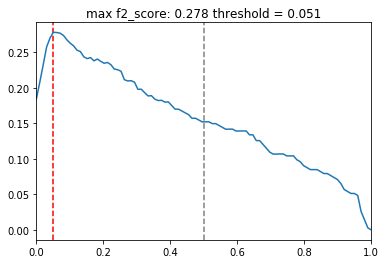

### threshold = 0.051
accuracy: 0.833
f2: 0.278
roc_auc: 0.695
### threshold = 0.500
accuracy: 0.960
f2: 0.152
roc_auc: 0.695


In [13]:
clf_diagnostic(clf_base, X_val, y_val, metric_fn=f2_score)

> ¿Por qué cae el accuracy entre los 2 puntos de corte?

**2. Pesos en la función de pérdida**

En general los modelos supervisados optimizan internamente una métrica (función de pérdida o costos). Muchas veces estas métricas admiten ponderadores; es decir, costos diferenciales para cada clase. 

Incrementando el costo del error de clasificación para la clase menos frecuente podemos obtener automáticamente scores que sirvan para optimizar métricas que ponderen más a la clase minoritaria, como es el F2 en este caso.

**Por ejemplo**, para un problema de clasificación con $K$ clases, la _log-loss_ o _cross-entropy_:

$$
- \sum_{c=1}^K y_{c} \log \hat{p}_{c}
$$

se puede modificar con pesos para cada clase: 

$$
- \sum_{c=1}^K w_{c} y_{c} \log \hat{p}_{c}
$$

tal que $w_{c}$ pondera a cada clase inversamente según su frecuencia. En particular, en `sklearn` los pesos se definen de manera tal que las observaciones de cada clase tengan la misma representación en los datos de entrenamiento:


c:\Users\Fran\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


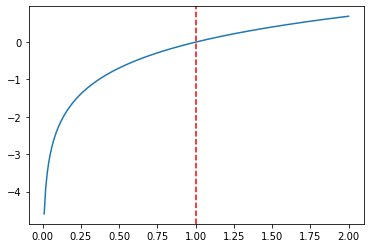

In [4]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0, 2, 200)
y = np.log(x)
plt.axvline(x=1, color="r", linestyle="--")
plt.plot(x, y)
plt.show()

In [22]:
n_samples = X_train.shape[0]
freq_classes = np.bincount(y_train)
n_classes = len(freq_classes)

print("raw frequencies:")
print(freq_classes)

ws = n_samples / (n_classes * freq_classes)
print("class weights:")
print(ws)
print(freq_classes * ws)

raw frequencies:
[9565  435]
class weights:
[ 0.52273915 11.49425287]
[5000. 5000.]


In [27]:
clf_weights = LGBMClassifier(is_unbalance=True, **params)
# NOTE for custom class weights, use scale_pos_weight
# (https://github.com/microsoft/LightGBM/issues/1299#issuecomment-379179552)

In [28]:
%%time
_ = clf_weights.fit(X_train, y_train)

Wall time: 347 ms


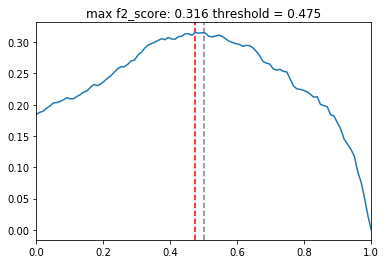

### threshold = 0.475
accuracy: 0.890
f2: 0.316
roc_auc: 0.696
### threshold = 0.500
accuracy: 0.900
f2: 0.312
roc_auc: 0.696


In [29]:
clf_diagnostic(clf_weights, X_val, y_val)

**3. Resampling**

Hay mútliples estrategias que remuestrean los datos de entrenamiento de manera tal que las clases tengan la misma frecuencia. 

La estrategia más simple es la de **random over-sampling**. 

Pueden revisar otras estrategias más sofisticadas en la [guía de `imblearn`](https://imbalanced-learn.org/stable/user_guide.html).

In [36]:
clf_ros = Pipeline([
    ('ros', RandomOverSampler(random_state=0)),
    ('clf', LGBMClassifier(**params)),
])

In [37]:
%%time
_ = clf_ros.fit(X_train, y_train)

Wall time: 554 ms


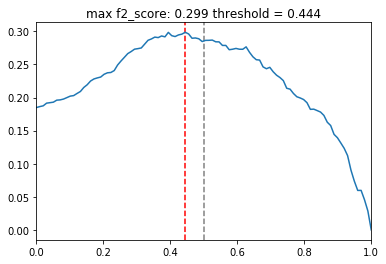

### threshold = 0.444
accuracy: 0.874
f2: 0.299
roc_auc: 0.691
### threshold = 0.500
accuracy: 0.902
f2: 0.287
roc_auc: 0.691


In [38]:
clf_diagnostic(clf_ros, X_val, y_val)

### Distribuciones de los scores

¡**OJO** con la escala de las predicciones! Puede ser importante conservar la interpretación de probabilidad de los scores, que con algunas estrategias se pierde...

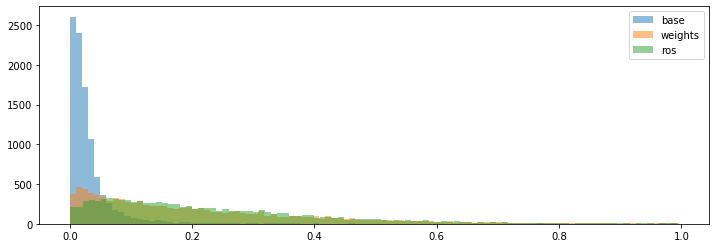

In [39]:
# density distribution of predictions of the 3 models
fig, ax = plt.subplots(figsize=(12, 4))
ax.hist(get_proba(clf_base, X_val), bins=100, label="base", alpha=.5)
ax.hist(get_proba(clf_weights, X_val), bins=100, label="weights", alpha=.5)
ax.hist(get_proba(clf_ros, X_val), bins=100, label="ros", alpha=.5)
plt.legend()
plt.show()

### Métricas de performance

Vamos a conservar el modelo que usa _class weights_ con un threshold de 0.5 y analizar distintas métricas de performance. 

**Nunca olvidar que la elección de métrica depende del problema!**

In [40]:
# usamos el modelo con class weights
y_val_pred_proba = clf_weights.predict_proba(X_val)[:, 1]
y_val_pred = y_val_pred_proba > 0.5

#### Bondad global del modelo

In [41]:
print(f"AUROC: {roc_auc_score(y_val, y_val_pred_proba):.4f}")

AUROC: 0.6964


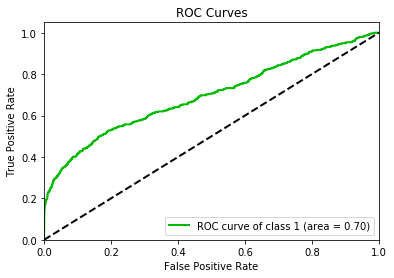

In [42]:
# plot the ROC curve
y_pred_ = clf_weights.predict_proba(X_val)
plot_roc(y_val, y_pred_, classes_to_plot=[1], plot_micro=False, plot_macro=False)
plt.show()
# NOTE exije las 2 columnas

AUROC es **simétrica** e **insensible al desbalance**. 

Esto es porque $FPR = FP / (FP + TN)$. En datos desbalanceados $TN$ tiene un peso grande y la $FPR$ tiende a quedarse en valores bajos, lo cual la vuelve poco informativa.

Puede haber cambios sensibles en la precisión no capturados por FPR -- por ejemplo:

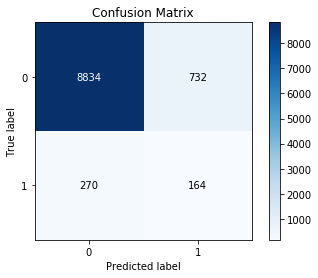

In [43]:
plot_confusion_matrix(y_val, y_val_pred, normalize=False)
plt.show()

In [44]:
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
print(f"precision = {tp / (tp + fp):.4f}")
print(f"FPR = {fp / (fp + tn):.4f}")

precision = 0.1830
FPR = 0.0765


In [45]:
# modelo que reduce en 100 los falsos positivos
tp_ = tp + 100
fp_ = fp - 100
tn_ = tn + 100
fn_ = fn - 100
print(f"precision = {tp_ / (tp_ + fp_):.4f}")
print(f"FPR = {fp_ / (fp_ + tn_):.4f}")

precision = 0.2946
FPR = 0.0661


La precision cambió sensiblemente pero FPR no captura esto! 

AUROC evalúa FPR (bondad para captar negativos) y TNR (bondad para captar positivos) "por separado" y con la misma ponderación. Por eso es **simétrica**: si invertimos la codificación del target, el resultado es el mismo.

Si queremos una métrica _global_ para el caso en el que los positivos son más importantes (los movimientos en los FP son importantes) podemos usar el **Area Under the Precision-Recall Curve** (AUPRC).

Sobre todo en datasets desbalanceados, dos modelos pueden tener AUROC similar pero muy distinta AUPRC! Vean por ejemplo [este post](https://sinyi-chou.github.io/).

In [46]:
print(f"AUPRC: {average_precision_score(y_val, y_val_pred_proba):.3f}")

AUPRC: 0.274


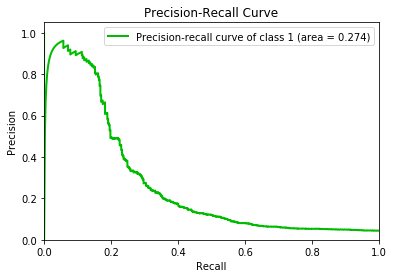

In [47]:
y_pred_ = clf_weights.predict_proba(X_val)
plot_precision_recall(y_val, y_pred_, classes_to_plot=[1], plot_micro=False,)
plt.show()

Tengan en cuenta que, a diferencia de AUROC, los valores de AUPRC dependen _mucho_ de la distribución del target, de modo que modelos de datasets con distinta distribución de clases no son inmediatamente comparables.

#### Métricas de clasificación

Ya sabemos que accuracy es poco informativa en datos desbalanceados.

Si el problema es asimétrico (nos interesan más los positivos que los negativos), podemos usar el F-score.

In [48]:
print(
    classification_report(y_val, y_val_pred, labels=clf_weights.classes_))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      9566
           1       0.18      0.38      0.25       434

    accuracy                           0.90     10000
   macro avg       0.58      0.65      0.60     10000
weighted avg       0.94      0.90      0.92     10000



: 

Para problemas "simétricos" con datos desbalanceados podemos usar:

* **Balanced accuracy**: es el promedio simple del _recall_ de cada clase (en el caso binario es el promedio simple de la _sensibilidad_ y la _especificidad_).

* **MCC** (Matthews Correlation Coefficient): es **muy** parecido a la V de Cramér (para el caso binario)! +1 indica una clasificación perfecta, 0 una predicción random y -1 una predicción invertida. Más detalles [acá](https://en.wikipedia.org/wiki/Phi_coefficient#Machine_learning). 

In [ ]:
print(f"Balanced accuracy = {balanced_accuracy_score(y_val, y_val_pred):.4f}")
print(f"MCC = {matthews_corrcoef(y_val, y_val_pred):.4f}")

Balanced accuracy = 0.6507
MCC = 0.2150


--------------------------------------

Sugerimos que entiendan las métricas analizando cómo se comporta cada una frente a un modelo _tonto_ (predice siempre la clase mayoritaria o que hace una predicción _random_).

In [ ]:
# el modelo mas simple:
y_majority = pd.Series(y_train).value_counts().index[0]
y_val_pred_0 = np.full_like(y_val, y_majority)

# el modelo mas tonto:
y_val_pred_proba_dummy = np.random.uniform(size=y_val.shape)
y_val_pred_dummy = (y_val_pred_proba_dummy > 0.5).astype(int)
